In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
folder = '/content/drive/MyDrive/Projects/BrainTumor/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1

In [3]:
folder = '/content/drive/MyDrive/Projects/BrainTumor/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1

In [4]:
listyes = os.listdir("/content/drive/MyDrive/Projects/BrainTumor/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("/content/drive/MyDrive/Projects/BrainTumor/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


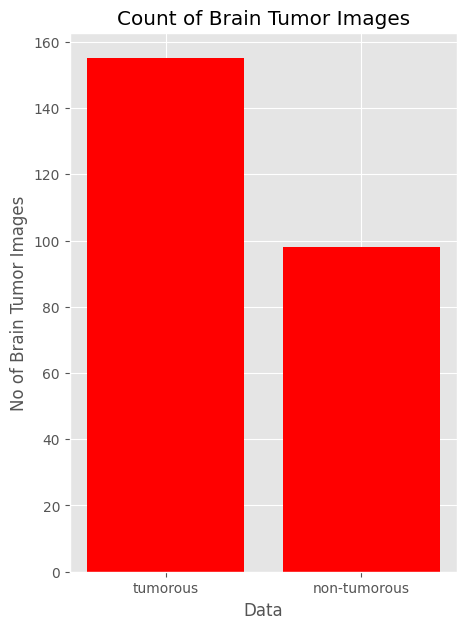

In [5]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [7]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [8]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [11]:
import os
import time

# Yol tanımları
yes_path = '/content/drive/MyDrive/Projects/BrainTumor/brain_tumor_dataset/yes'
no_path = '/content/drive/MyDrive/Projects/BrainTumor/brain_tumor_dataset/no'
augmented_data_path = 'augmented_data/'

# Dizini kontrol et ve oluştur
if not os.path.exists(augmented_data_path):
    os.makedirs(augmented_data_path)
if not os.path.exists(augmented_data_path + 'yes'):
    os.makedirs(augmented_data_path + 'yes')
if not os.path.exists(augmented_data_path + 'no'):
    os.makedirs(augmented_data_path + 'no')

# Zaman ölçümü
start_time = time.time()

# Veriyi artırma işlemi
augmented_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path + 'yes')
augmented_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path + 'no')

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


Execution time: 162.39 seconds


In [12]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [13]:
data_summary(augmented_data_path)

Number of sample: 2064
1084 Number of positive sample in percentage: 52.51937984496124%
980 Number of negative sample in percentage: 47.48062015503876%


In [14]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image


In [17]:
import os

file_path = '/content/augmented_data/yes/aug_Y100_0_1070.jpg'
if not os.path.isfile(file_path):
    print(f"Dosya mevcut değil: {file_path}")


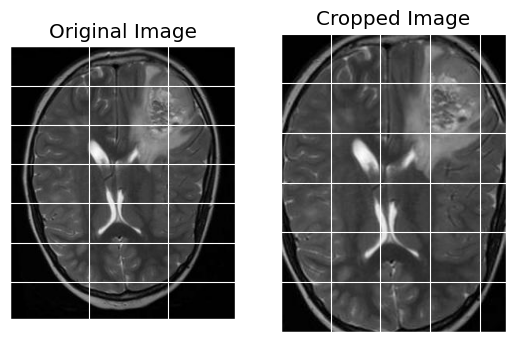

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
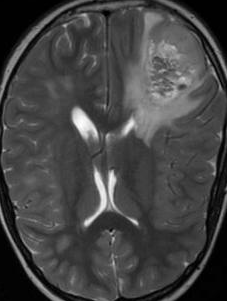

In [19]:
img = cv2.imread('/content/augmented_data/yes/aug_Y100_0_1070.jpg')
crop_brain_tumor(img, True)

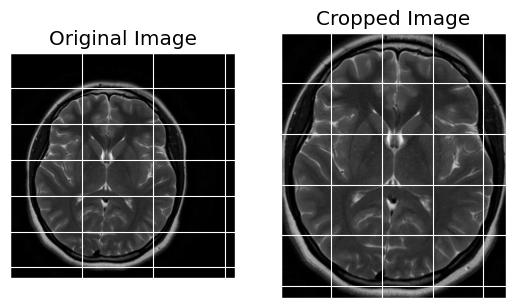

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
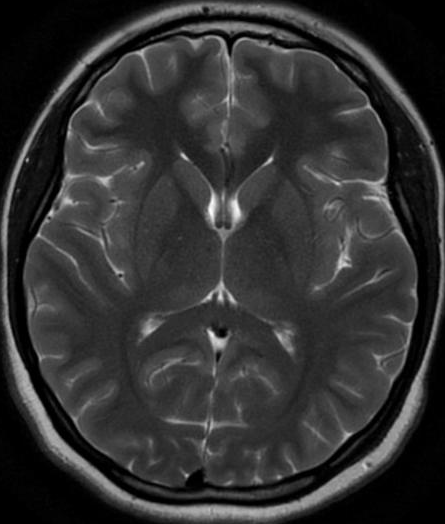

In [23]:
img = cv2.imread('/content/augmented_data/no/aug_1 no._0_16.jpg')
crop_brain_tumor(img, True)

In [24]:
folder1 = '/content/augmented_data/no/'
folder2 = '/content/augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [25]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [26]:
augmented_path = '/content/augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [27]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

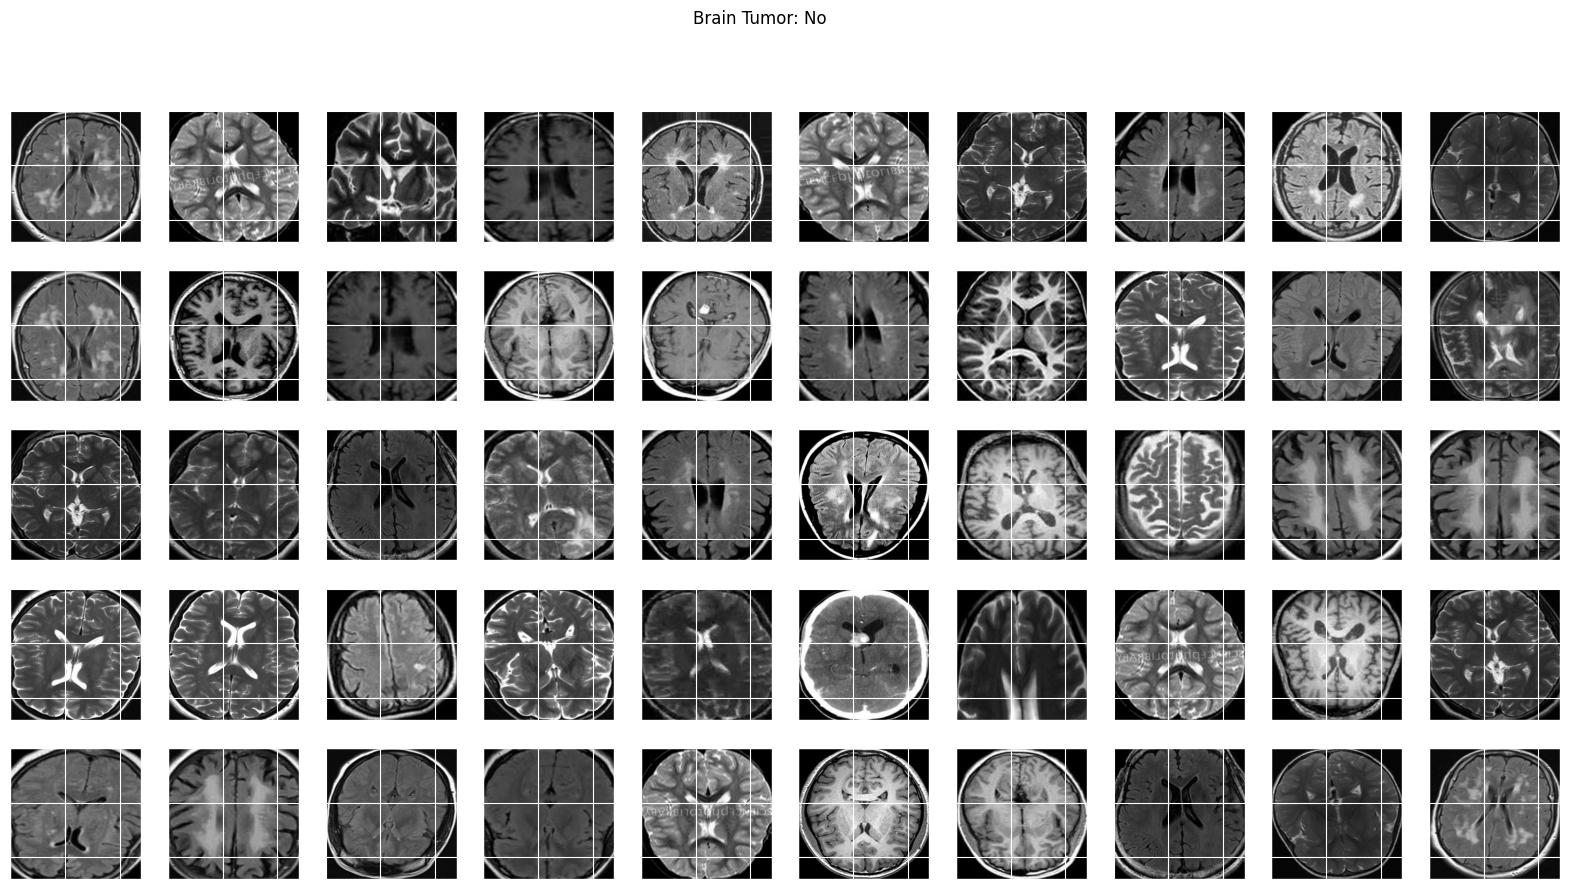

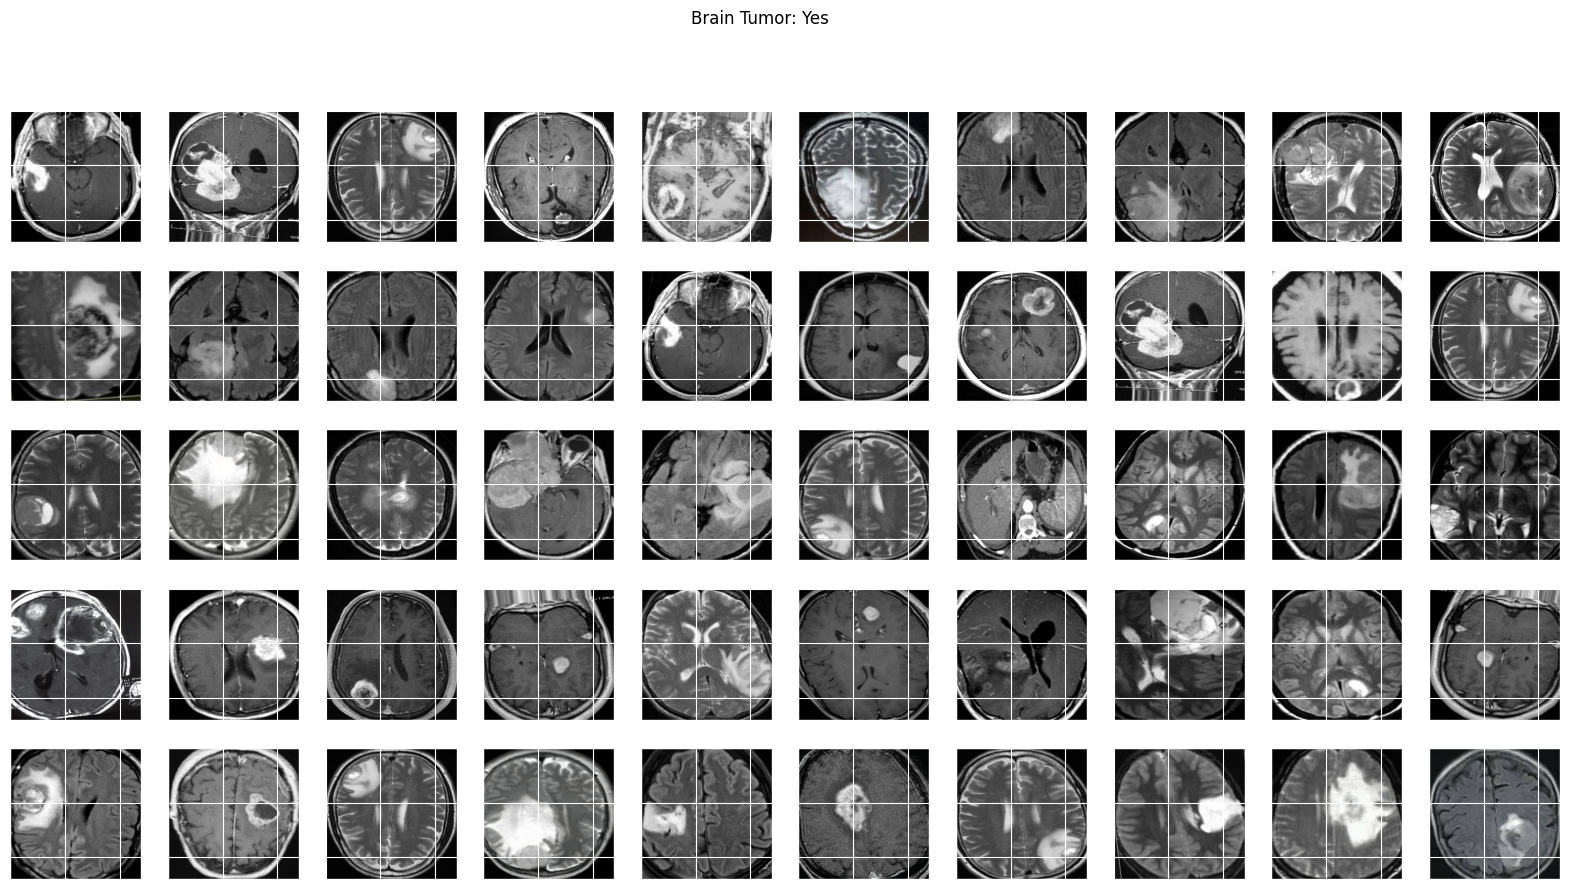

In [28]:
plot_sample_images(X,y)

In [29]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [30]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [31]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [32]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [33]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [34]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [35]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [40]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [41]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [42]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,979):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [43]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [44]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1445 images belonging to 2 classes.


In [45]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [46]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 146 images belonging to 2 classes.


In [47]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [48]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [52]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Dosya yolu
filepath = 'model.keras'

# Callbacks tanımları
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

# Callbacks'ı model.fit() içine geçirebilirsiniz


In [55]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [56]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.4896 - loss: 0.7583
Epoch 1: val_loss improved from inf to 0.66401, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.4917 - loss: 0.7567 - val_accuracy: 0.5479 - val_loss: 0.6640 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.4953 - loss: 0.7515
Epoch 2: val_loss improved from 0.66401 to 0.66153, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.4969 - loss: 0.7503 - val_accuracy: 0.6164 - val_loss: 0.6615 - learning_rate: 1.0000e-04


In [59]:
import os

# Model ağırlıkları dizinini oluştur
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')

# Ağırlıkları kaydet
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)


In [61]:
model_01.load_weights("/content/model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.5796 - loss: 0.6606
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5942 - loss: 0.6643


In [62]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6616343855857849
Validation Acc: 0.5890411138534546
Testing Loss: 0.6718217730522156
Testing Acc: 0.5838709473609924


In [63]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step   


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [64]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

In [66]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('/content/model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [67]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [68]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5512 - loss: 0.7018
Epoch 1: val_loss did not improve from 0.66153
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5497 - loss: 0.7034 - val_accuracy: 0.2192 - val_loss: 0.8663 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5347 - loss: 0.7149
Epoch 2: val_loss improved from 0.66153 to 0.55946, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - accuracy: 0.5367 - loss: 0.7141 - val_accuracy: 0.7877 - val_loss: 0.5595 - learning_rate: 1.0000e-04


In [70]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')

# Ağırlıkları kaydet
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [71]:
model_02.load_weights("/content/model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.7866 - loss: 0.5704
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - accuracy: 0.5936 - loss: 0.6786


In [74]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)

model_03.load_weights('/content/model_weights/vgg19_model_02.weights.h5')


sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])